In [270]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [271]:
import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
from ress.utils import plotVectors

In [272]:
# Plot parameters
sns.set()
# Seven hls color palette
current_palette_7 = sns.color_palette("hls", 7)
sns.set_palette(current_palette_7)

%pylab inline
pylab.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['ytick.major.size'] = 0
# rcParams.keys()

Populating the interactive namespace from numpy and matplotlib


In [273]:
# Avoid inaccurate floating values (for inverse matrices in dot product for instance)
# See https://stackoverflow.com/questions/24537791/numpy-matrix-inversion-rounding-errors
np.set_printoptions(suppress=True)

In [274]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$$
\newcommand\norm[1]{\left\lVert#1\right\rVert} 
\DeclareMathOperator{\Tr}{Tr}
\newcommand\bs[1]{\boldsymbol{#1}}
\newcommand\argmin[1]{\underset{\bs{#1}}{\arg\min}}
\newcommand\argmax[1]{\underset{\bs{#1}}{\arg\max}}
$$

# 2.12 Example - Principal Components Analysis

<span class='pquote'>
    This content is part of a series following the chapter 2 on linear algebra from the [Deep Learning Book](http://www.deeplearningbook.org/) by Goodfellow, I., Bengio, Y., and Courville, A. (2016). It aims to provide intuitions/drawings/python code on mathematical theories and is constructed as my understanding of these concepts.
</span>


This is the last chapter of the Linear Algebra part of the Deep Learning Book. The goal is to use our previous knoledge from chapters 1 to 11 to study a widely used algorithm: the Principal Components Analysis. Be sure to check previous chapters.

Dimensions are a crucial topic in data science. The dimensions are all the features of the dataset. For instance, if you are looking at a dataset containing pieces of music, dimensions could be the genre, the length of the piece, the number of instruments, the presence of a singer etc. You can imagine all these dimensions as different columns. When there is only two dimensions, it is very convenient to plot: you can use the $x$- and $y$-axis. Add color and you can represent a third dimension. It is very similar if you have tens or hundereds of dimensions.

When you have that many dimensions it happens that some of them are correlated. For instance, we can reasonably think that the genre dimension will correlate with the instruments dimensions in our previous example. It would be nice to have a way to reduce these dimensions while keeping all the information.

The aim of principal components analysis (PCA) is generaly to reduce the number of dimensions of a dataset where dimensions are not completly decorelated. PCA provides us with a new set of dimensions, the principal components (PC). They are ordered: the first PC is the dimension having the largest variance. In addition, each PC is orthogonal to the preceding one. Remember that orthogonal vectors means that their dot product is equal to $0$ (see [2.6]()). This means that each PC is decorelated to the preceding one. It is way better than feature selection where you loose a lot of information.

### Example 1.

Unit vectors is an example of orthogonal vectors:

<img src="images/orthoVec.png" alt="orthoVec" width="300">


Therefore, it is possible to keep only the first PCs and reduce dimensionaly without losing much information.

## Describing the problem

The process is precisely described in the book so I will just add some steps, references and explanations.

The problem can expressed as finding a function that convert a set of data points from $\mathbb{R}^n$ to $\mathbb{R}^l$. This means that we change the number of dimensions of our dataset. We also need a function that can decode back from the transformed dataset to the initial one.

<img src="images/problem.png" alt="problem" width="80%">

So the first step is to understand the shape of the data. $x^{(i)}$ is one data point containing $n$ dimensions. Let's have our $m$ data points organized as column vectors (one column per point):

$$
\bs{x}=
\begin{bmatrix}
    x^{(1)} & x^{(2)} & \cdots & x^{(m)}
\end{bmatrix}
$$

If we deploy the $n$ dimensions of our data points we will have:

$$
\bs{x}=
\begin{bmatrix}
    x_1^{(1)} & x_1^{(2)} & \cdots & x_1^{(m)}\\\\
    x_2^{(1)} & x_2^{(2)} & \cdots & x_2^{(m)}\\\\
    \cdots & \cdots & \cdots & \cdots\\\\
    x_n^{(1)} & x_n^{(2)} & \cdots & x_n^{(m)}
\end{bmatrix}
$$

We can also write:

$$
\bs{x}=
\begin{bmatrix}
    x_1\\\\
    x_2\\\\
    \cdots\\\\
    x_n
\end{bmatrix}
$$

$c$ will have the exact same dimensions:

$$
\bs{c}=
\begin{bmatrix}
    c_1\\\\
    c_2\\\\
    \cdots\\\\
    c_n
\end{bmatrix}
$$

## Adding some constraints: the decoding function

The encoding function $f()$ transforms $\bs{x}$ into $\bs{c}$ and the decoding function transforms back $\bs{c}$ into an approximation of $\bs{x}$. To keep things simple, PCA will respect some constraints:

### Constraint 1.

The decoding function has to be a simple matrix multiplication:

$$
g(\bs{c})=\bs{Dc}
$$

By applying the matrix $\bs{D}$ to the dataset from the new coordinates system we should get back to the initial coordinate system.

### Constraint 2.

The columns of $\bs{D}$ must be orthogonal.

### Constraint 3.

The columns of $\bs{D}$ must have unit norm.

## Finding the encoding function

Important: For now we will consider only **one data point**. Thus we will have the following dimensions for these matrices (note that $\bs{x}$ and $\bs{c}$ are column vectors):

<img src="images/decoding.png" alt="decoding" width="250">

We want a decoding function that is a simple matrix multiplication. For that reason, we have $g(\bs{c})=\bs{Dc}$. We will find the encoding function from the decoding function. We want to minimize the error between the decoded data point and the actual data point. With our previous notation, this means reducing the distance between $\bs{x}$ and $g(\bs{c})$. As an indicator of this distance, we will use the squared $L^2$ norm (see [2.5]()):

$$
\norm{\bs{x} - g(\bs{c})}_2^2
$$

This is what we want to minimize. Let's call $\bs{c}^*$ the optimal $\bs{c}$. Mathematically it can be written:

$$
\bs{c}^* = \underset{c}{\arg\min} \norm{\bs{x} - g(\bs{c})}_2^2
$$

This means that we want to find the values of the vector $\bs{c}$ such that $\norm{\bs{x} - g(\bs{c})}_2^2$ is as small as possible.

If you have a look back to [2.5]() you can see that the squared $L^2$ norm can be expressed as:

$$
\norm{\bs{y}}_2^2 = \bs{y}^\text{T}\bs{y}
$$

We named the variable $\bs{y}$ to avoid confusion with our $\bs{x}$. Here $\bs{y}=\bs{x} - g(\bs{c})$

Thus the equation that we want to minimize becomes:

$$
(\bs{x} - g(\bs{c}))^\text{T}(\bs{x} - g(\bs{c}))
$$

Since the transpose respects addition we have:

$$
(\bs{x}^\text{T} - g(\bs{c})^\text{T})(\bs{x} - g(\bs{c}))
$$

By the distributive property (see [2.2]()) we can develop:

$$
\bs{x^\text{T}x} - \bs{x}^\text{T}g(\bs{c}) -  g(\bs{c})^\text{T}\bs{x} + g(\bs{c})^\text{T}g(\bs{c})
$$

The commutative property (see [2.2]()) tells us that:

$$
\bs{x^\text{T}y} = \bs{y^\text{T}x}
$$

We can use that in the previous equation:

$$
\bs{x}^\text{T}g(\bs{c}) = g(\bs{c})^\text{T}\bs{x}
$$

So it becomes:

$$
\bs{x^\text{T}x} -2\bs{x}^\text{T}g(\bs{c}) + g(\bs{c})^\text{T}g(\bs{c})
$$

The first term $\bs{x^\text{T}x}$ does not depends on $\bs{c}$ and since we want to minimize the function according to $\bs{c}$ we can just get off this term. We simplify to:

$$
\bs{c}^* = \underset{c}{\arg\min} -2\bs{x}^\text{T}g(\bs{c}) + g(\bs{c})^\text{T}g(\bs{c})
$$

Since $g(\bs{c})=\bs{Dc}$:

$$
\bs{c}^* = \underset{c}{\arg\min} -2\bs{x}^\text{T}\bs{Dc} + (\bs{Dc})^\text{T}\bs{Dc}
$$

With $(\bs{Dc})^\text{T}=\bs{c}^\text{T}\bs{D}^\text{T}$ (see [2.2]()). So we have:

$$
\bs{c}^* = \underset{c}{\arg\min} -2\bs{x}^\text{T}\bs{Dc} + \bs{c}^\text{T}\bs{D}^\text{T}\bs{Dc}
$$

As we saw in [2.6](), $\bs{D}^\text{T}\bs{D}=\bs{I}_l$ because $\bs{D}$ is orthogonal (actually, it is [semi-orthogonal](https://en.wikipedia.org/wiki/Semi-orthogonal_matrix) if $n \neq l$) and their columns have unit norm. We can replace in the equation:

$$
\bs{c}^* = \underset{c}{\arg\min} -2\bs{x}^\text{T}\bs{Dc} + \bs{c}^\text{T}\bs{I}_l\bs{c}
$$

$$
\bs{c}^* = \underset{c}{\arg\min} -2\bs{x}^\text{T}\bs{Dc} + \bs{c}^\text{T}\bs{c}
$$

### Minimizing the function

So far so good! Now the goal is to find the minimum of the function $- 2\bs{x}^\text{T}\bs{Dc} + \bs{c}^\text{T}\bs{c}$. One widely used way of doing that is to use the **gradient descent** algorithm. It is not the focus of this chapter but we will say a word about it (see [4.3]() of the Deep Learning Book for more details). The main idea is that the sign of the derivative of the function at a specific value of $x$ tells you if you need to increase or decrease $x$ to reach the minimum. When the slope is near $0$, the minimum should have been reached.

<img src="images/gradientDescent.png" alt="gradientDescent" width="400">

However, functions with local minima can trouble the descent:

<img src="images/localMinima.png" alt="localMinima" width="400">

These examples are in 2 dimensions but the principle stands for higher dimensional functions. The gradient is a vector containing the partial derivatives of all dimensions. Its mathematical notation is $\nabla_xf(\bs{x})$.

### Calculating the gradient of the function

Here we want to minimize through each dimension of $\bs{c}$. We are looking for a slope of $0$. The equation is:

$$
\nabla_c(-2\bs{x}^\text{T}\bs{Dc} + \bs{c}^\text{T}\bs{c})=0
$$

Let's take these terms separately to calculate the derivative according to $\bs{c}$. 

$$
\frac{d(-2\bs{x}^\text{T}\bs{Dc})}{d\bs{c}} = -2\bs{x}^\text{T}\bs{D}
$$

The second term is $\bs{c}^\text{T}\bs{c}$. We can develop the vector $\bs{c}$ and calculate the derivative for each element:

$$
\begin{align*}
\frac{d(\bs{c}\text{T}\bs{c})}{d\bs{c}} &=
\left(\frac{d(\bs{c}_1^2 + \bs{c}_2^2 + \cdots + \bs{c}_l^2)}{d\bs{c}_1},
\frac{d(\bs{c}_1^2 + \bs{c}_2^2 + \cdots + \bs{c}_l^2)}{d\bs{c}_2},
\cdots,
\frac{d(\bs{c}_1^2 + \bs{c}_2^2 + \cdots + \bs{c}_l^2)}{d\bs{c}_l}\right) \\\\
&=(2\bs{c}_1, 2\bs{c}_2, \cdots, 2\bs{c}_l)\\\\
&=2(\bs{c}_1, \bs{c}_2, \cdots, \bs{c}_l)\\\\
&=2\bs{c}
\end{align*}
$$

So we can progress in our derivatives:

$$
\nabla_c(-2\bs{x}^\text{T}\bs{Dc} + \bs{c}^\text{T}\bs{c})=0\\\\
-2\bs{x}^\text{T}\bs{D} + 2\bs{c}=0\\\\
-2\bs{D}^\text{T}\bs{x} + 2\bs{c}=0\\\\
\bs{c}=\bs{D}^\text{T}\bs{x}
$$

Great! We found the encoding function! Here are its dimensions:

<img src="images/encoding.png" alt="encoding" width="250">


To go back from $\bs{c}$ to $\bs{x}$ we use $g(\bs{c})=\bs{Dc}$:

$$
r(\bs{x}) = g(f(\bs{x})=\bs{D}\bs{D}^\text{T}\bs{x}
$$

<img src="images/reconstruction.png" alt="reconstruction" width="300">

## Finding $\bs{D}$

The next step is to find the matrix $\bs{D}$. Recall that the purpose of the PCA is to change the coordinate system in order to maximize the variance along the first dimensions of the projected space. This is equivalent to minimizing the error between data points and their reconstruction ([cf here](https://stats.stackexchange.com/questions/32174/pca-objective-function-what-is-the-connection-between-maximizing-variance-and-m)). See bellow the covariance matrix to have more details.

<blockquote>
Maximizing the variance corresponds to minimizing the error of the reconstruction.
</blockquote>

### The Frobenius norm

Since we have to take all points into account (the same matrix $\bs{D}$ will be used for all points) we will use the Frobenius norm of the errors (see [2.5]()) which is the equivalent of the $L^2$ norm for matrices. Here the formula of the Frobenius norm:

$$
\norm{\bs{A}}_F=\sqrt{\sum_{i,j}A^2_{i,j}}
$$

It is like if you unroll the matrix to end up with a one dimensional vector and that you take the $L^2$ norm of this vector.

We will call $\bs{D}^*$ the optimal $\bs{D}$ (in the sense that the error is as small as possible). We have:

$$
\bs{D}^* = \underset{\bs{D}}{\arg\min} \sqrt{\sum_{i,j}(x_j^{(i)}-r(\bs{x}^{(i)})_j})^2
$$

With the constraint that $\bs{D}^\text{T}\bs{D}=\bs{I}_l$ because we choose the constraint of having the columns of $\bs{D}$ orthogonal.

### The first principal component

We will start to find only the first principal component (PC). For that reason, we will have $l=1$. So the matrix $\bs{D}$ will have the shape $(n \times 1)$: it is a simple column vector. Since it is a vector we will call it $\bs{d}$:

<img src="images/l1.png" alt="l1" width="100">

We can therefore remove the sum over $j$ and the square root since we will take the squared $L^2$ norm:

$$
\bs{d}^* = \underset{\bs{d}}{\arg\min} \sum_{i}\norm{(\bs{x}^{(i)}-r(\bs{x}^{(i)}))}_2^2
$$


We have also seen that:

$$
r(\bs{x})=\bs{D}\bs{D}^\text{T}\bs{x}
$$

Since we are looking only for the first PC:

$$
r(\bs{x})=\bs{d}\bs{d}^\text{T}\bs{x}
$$

We can plug $r(\bs{x})$ into the equation:

$$
\bs{d}^* = \underset{\bs{d}}{\arg\min} \sum_{i}\norm{\bs{x}^{(i)}-\bs{dd}^\text{T}\bs{x}^{(i)}}_2^2
$$

Because of the constraint 3. (the columns of $\bs{D}$ have unit norms) we have $\norm{\bs{d}}_2 = 1$. $\bs{d}$ is one of the columns of $\bs{D}$ and thus has a unit norm.

$$
\bs{d}^* = \underset{\bs{d}}{\arg\min} \sum_{i}\norm{\bs{x}^{(i)}-\bs{dd}^\text{T}\bs{x}^{(i)}}_2^2
$$

$$
\bs{d}^* = \underset{\bs{d}}{\arg\min} \sum_{i}\norm{\bs{x}^{(i)}-\bs{d}^\text{T}\bs{x}^{(i)}\bs{d}}_2^2
$$

$$
\bs{d}^* = \underset{\bs{d}}{\arg\min} \sum_{i}\norm{\bs{x}^{(i)}-\bs{x}^{(i)\text{T}}\bs{dd}}_2^2
$$

Instead of using the sum along the $m$ data points $\bs{x}$ we can have the matrix $\bs{X}$ which gather all the observations:

$$
\bs{X} = \begin{bmatrix}
    \bs{x}^{(1)\text{T}}\\\\
    \bs{x}^{(2)\text{T}}\\\\
    \cdots\\\\
    \bs{x}^{(m)\text{T}}
\end{bmatrix}=
\begin{bmatrix}
    \bs{x}_1^{(1)} & \bs{x}_2^{(1)} & \cdots & \bs{x}_n^{(1)}\\\\
    \bs{x}_1^{(2)} & \bs{x}_2^{(2)} & \cdots & \bs{x}_n^{(2)}\\\\
    \cdots & \cdots & \cdots & \cdots\\\\
    \bs{x}_0^{(m)} & \bs{x}_1^{(m)} & \cdots & \bs{x}_n^{(m)}\\\\
\end{bmatrix}
$$

and

$$
\bs{d}^* = \underset{\bs{d}}{\arg\min} \norm{\bs{X}-\bs{X}\bs{dd}^\text{T}}_\text{F}^2
$$

with the constraint that $\bs{dd}^\text{T}=1$.

### Using the Trace operator

We will now use the Trace operator (see [2.10]()) to simplify the equation to minimize. Recall that:

$$
\norm{\bs{A}}_F=\sqrt{\Tr({\bs{AA}^T})}
$$

So here $\bs{A}=\bs{X}-\bs{X}\bs{dd}^\text{T}$. So we have:

$$
\bs{d}^* = \underset{\bs{d}}{\arg\min} \Tr{((\bs{X}-\bs{Xdd}^\text{T})}(\bs{X}-\bs{Xdd}^\text{T})^\text{T})
$$

Since we can cycle the order of the matrices in a Trace (see [2.10]()) we can write:

$$
\begin{align*}
\bs{d}^* &= \argmin{d} \Tr{((\bs{X}-\bs{Xdd}^\text{T})^\text{T}}(\bs{X}-\bs{Xdd}^\text{T}))\\\\
&=\argmin{d} \Tr{((\bs{X}^\text{T}-(\bs{Xdd}^\text{T})^\text{T})}(\bs{X}-\bs{Xdd}^\text{T}))
\end{align*}
$$

And $(\bs{Xdd}^\text{T})^\text{T}=(\bs{d}^\text{T})^\text{T}\bs{d}^\text{T}\bs{X}^\text{T}=\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}$. Let's plug that into our equation:


$$
\begin{align*}
\bs{d}^* &= \argmin{d} \Tr{(\bs{X}^\text{T}-\bs{d}\bs{d}^\text{T}\bs{X}^\text{T})}(\bs{X}-\bs{Xdd}^\text{T}))\\\\
&= \argmin{d} \Tr{(\bs{X}^\text{T}\bs{X}-\bs{X}^\text{T}\bs{Xdd}^\text{T} -\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{X} +\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{Xdd}^\text{T}})\\\\
&= \argmin{d} \Tr{(\bs{X}^\text{T}\bs{X})} - \Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})}
- \Tr{(\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{X})} + \Tr{(\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{Xdd}^\text{T})}
\end{align*}
$$

We can remove the first term that not depends on $d$:

$$
\bs{d}^* = \argmin{d} - \Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})}
- \Tr{(\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{X})} + \Tr{(\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{Xdd}^\text{T})}
$$

Still because of the cycling property of a trace, we have

$$
\Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})} = \Tr{(\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{X})}
$$

We can simplify to:

$$
\bs{d}^* = \argmin{d} -2\Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})}
 + \Tr{(\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{Xdd}^\text{T})}
$$

and then

$$
\bs{d}^* = \argmin{d} -2\Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})}
 + \Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T}\bs{d}\bs{d}^\text{T})}
$$

Because of the constraint $\bs{dd}^\text{T}=1$:

$$
\begin{align*}
\bs{d}^* &= \argmin{d} -2\Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})}
 + \Tr{(\bs{X}^\text{T}\bs{Xd}\bs{d}^\text{T})}\textrm{ subject to }\bs{dd}^\text{T}=1\\\\
&= \argmin{d} -\Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})}\textrm{ subject to }\bs{dd}^\text{T}=1\\\\
&=\argmax{d} \Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})}\textrm{ subject to }\bs{dd}^\text{T}=1
\end{align*}
$$

and with the cycling property:

$$
\bs{d}^* = \argmax{d} \Tr{(\bs{d}^\text{T}\bs{X}^\text{T}\bs{Xd})} \textrm{ subject to }\bs{dd}^\text{T}=1
$$

### Eigendecomposition

We will see that we can find the maximum of the function by calculating the eigenvectors of $\bs{X^\text{T}X}$.


### Covariance matrix

As we wrote above, the optimization problem of maximizing the variance of the components and minimizing the error between the reconstructed and the actual data are equivalent. Actually, if you look at the formula of $\bs{d}$ you can see that there is the term $\bs{X\text{T}X}$ in the middle. It is more clear now that we have the formula of $\bs{d}^*$.

Actually if we have centered our data around 0 (see bellow for more details about centering), $\bs{X^\text{T}X}$ is the covariance matrix (see [this Quora question]()).

The covariance matrix is a $n$ by $n$ matrix ($n$ being the number of dimensions). Its diagonal is the variance of the corresponding dimensions and the other cells are the covariance between the two corresponding dimensions (the amount of redundancy).

This means that the largest covariance we have between two dimensions the more redundancy exists between these dimensions. This also means that the best-fit line is associated with small errors if the covariance is hight. To maximize the variance and minimize the covariance (in order to decorrelate the dimensions) means that the ideal covariance matrix is a diagonal matrix (non-zero values in the diagonal only). Therefore the diagonalization of the covariance matrix will give us the optimal solution.


Since we centered the data as a preprocessing the covariance matrix is

$$\bs{C_X}=\bs{X^\text{T}X}$$



This means that maximizing $\Tr{(\bs{d}^\text{T}\bs{X}^\text{T}\bs{Xd})}$

https://arxiv.org/pdf/1404.1100.pdf

### Example 2.

As an example we will create again a 2D data set (like in [2.9]()). To see the effect of the PCA we will introduce some correlations between the two dimensions. Let's create 100 data points with 2 dimensions:

In [277]:
np.random.seed(123)
x = 5*np.random.rand(100)
y = 2*x + 1 + np.random.randn(100)

x = x.reshape(100, 1)
y = y.reshape(100, 1)

X = np.hstack([x, y])
X.shape

(100, 2)

Let's plot the data:

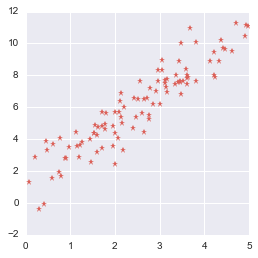

In [278]:
plt.plot(X[:,0], X[:,1], '*')

Highly correlated data means that the dimensions are redundant. It is possible to predict one from the other without losing much information.

The first processing we will do is to center the data around 0. PCA is a regression model without intercept and the first component is thus necessarly crossing the origin.

Here is a simple function that substract the mean of each column to each data point of this column. It has the effect of centering the data point around 0.

In [279]:
def centerData(X):
    X = X.copy()
    X -= np.mean(X, axis = 0)
    return X

So let's center our data $\bs{X}$ around 0 for both dimensions:

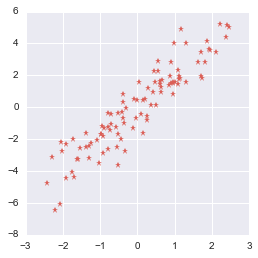

In [280]:
X_centered = centerData(X)
plt.plot(X_centered[:,0], X_centered[:,1], '*')

We can now look for PCs. We saw that they correspond to values taken by $\bs{d}$ that maximize the following function:

$$
\bs{d}^* = \argmax{d} \Tr{(\bs{d}^\text{T}\bs{X}^\text{T}\bs{Xd})} \textrm{ subject to }\bs{dd}^\text{T}=1
$$

To find $\bs{d}$ we can calculate the eigenvectors of $\bs{X^\text{T}X}$ (see [2.7]() for more details about eigendecomposition). So let's do that:

In [281]:
eigVals, eigVecs = np.linalg.eig(X_centered.T.dot(X_centered))
eigVecs

array([[-0.91116273, -0.41204669],
       [ 0.41204669, -0.91116273]])

These are the vectors maximizing our function. Each column vector is associated with an eigenvalue. The vector associated with the larger eigenvalue tells us the direction associated with the larger variance in our data. To check that, we will plot these vectors along with the data. 

(-3, 3)

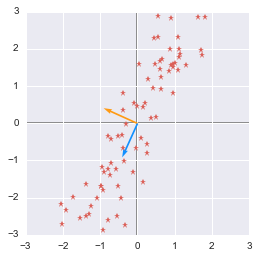

In [282]:
plotVectors(eigVecs.T, ['#FF9A13', '#1190FF'])
plt.plot(X1[:,0], X1[:,1], '*')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

In [283]:
sns.set_style()

We can see that the blue vector direction corresponds to oblique shape of our data. The idea is that if you project the data points on the line corresponding to the blue vector direction you will have the more spreading of the data. Look at the following figure:

<img src="images/variance.png" alt="variance" width="400">

When you project data points on the pink line they are really spread. This line has the direction that maximize the variance of the data points. It is the same for the figure above: our blue vector has the direction where data point projection has the higher variance. Then the second eigenvector is orthogonal to the first. It is the second eigenvector so let's check that well the one associated with the bigger eigenvalue:

In [178]:
eigVals

array([  18.04730409,  798.35242844])

So yes, the second vector corresponds to bigger eigenvalue.

Now that we have found the matrix $\bs{d}$ we will use the encoding function to rotate the data. The goal of the rotation is to end up with a new coordinate system where data is uncorrelated and then where the basis axes gather all the variance. It is then possible to keep only few axes: this is the purpose of dimensionality reduction.

Recall that the encoding function is:

$$
\bs{c}=\bs{D}^\text{T}\bs{x}
$$

$\bs{D}$ is the eigenvectors we calculated before. In addition, this formula corresponds to only one data point where dimensions are the rows of $\bs{x}$. In our case, we will apply it for all data points and since $\bs{X}$ has dimensions on the columns we need to transpose it.

(-5, 5)

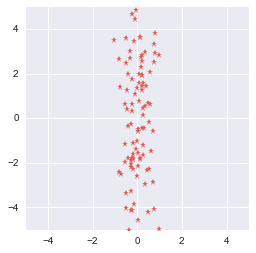

In [184]:
X_new = eigVecs.T.dot(X_centered.T)

plt.plot(eigVecs.T.dot(X_centered.T)[0, :], eigVecs.T.dot(X_centered.T)[1, :], '*')
plt.xlim(-5, 5)
plt.ylim(-5, 5)

It worked! The rotation transformed our dataset that have now the more variance on one of the basis axis. You could keep only this dimension and have a fairly good representation of the data.

### About the unit norm constraint

We saw that the maximization is subject to $\bs{dd}^\text{T}=1$. This means that the solution vector has to be a unit vector. Without this constraint, you could scale $\bs{d}$ up to the infinity to increase the function to maximize (see [here](https://stats.stackexchange.com/questions/117695/why-is-the-eigenvector-in-pca-taken-to-be-unit-norm)). For instance, let's see some vectors $\bs{x}$ that could maximize the function:

In [288]:
d = np.array([[12], [26]])
d.T.dot(X.T).dot(X).dot(d)

array([[ 4165298.04389264]])

However this $\bs{d}$ has not a unit norm (since $\bs{d}$ is a column vector we use the transpose of $\bs{dd}^\text{T}$ (see [2.2]()):

In [292]:
d.T.dot(d)

array([[820]])

The eigenvectors have unit norm and thus respect the constraint:

In [296]:
eigVecs[:,0].dot(eigVecs[:,0].T)

1.0

and

In [297]:
eigVecs[:,1].dot(eigVecs[:,1].T)

1.0

# References

https://math.stackexchange.com/questions/1377764/derivative-of-vector-and-vector-transpose-product

http://www4.ncsu.edu/~slrace/LinearAlgebra2017/Slides/PCAPrint.pdf

https://stats.stackexchange.com/questions/318625/why-do-the-leading-eigenvectors-of-a-maximize-texttrdtad

https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

https://www.cs.bgu.ac.il/~inabd171/wiki.files/lecture14_handouts.pdf

https://brilliant.org/wiki/principal-component-analysis/#from-approximate-equality-to-minimizing-function



https://arxiv.org/pdf/1404.1100.pdf

https://www.cs.bgu.ac.il/~inabd171/wiki.files/lecture14_handouts.pdf


https://en.wikipedia.org/wiki/Semi-orthogonal_matrix

### Intuition about PCA

- https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/

### Link between variance maximized and error minimized:

- https://stats.stackexchange.com/questions/130721/what-norm-of-the-reconstruction-error-is-minimized-by-the-low-rank-approximation

- https://stats.stackexchange.com/questions/32174/pca-objective-function-what-is-the-connection-between-maximizing-variance-and-m

### Centering data

- https://www.quora.com/Why-do-we-need-to-center-the-data-for-Principle-Components-Analysis
- https://stats.stackexchange.com/questions/22329/how-does-centering-the-data-get-rid-of-the-intercept-in-regression-and-pca

### Unit norm constraint

- https://stats.stackexchange.com/questions/117695/why-is-the-eigenvector-in-pca-taken-to-be-unit-norm

In [204]:
d = np.array([[-0.9219176], [-0.38738604]])
print d.T.dot(d)
d.T.dot(X.T).dot(X).dot(d)

[[ 1.00000001]]


array([[ 2603.84104568]])

In [194]:
(X.T).dot(X)

array([[  779.10674359,  1809.61302066],
       [ 1809.61302066,  4325.30791113]])

In [202]:
np.linalg.eig((X.T).dot(X))

(array([   18.71468582,  5085.69996889]), array([[-0.9219176 , -0.38738604],
        [ 0.38738604, -0.9219176 ]]))